# Introduction

This Kernel objective is to explore the dataset for Prostate cANcer graDe Assessment (PANDA) Challenge.  

Prostate cancer is the second most common cancer among males worldwide that results in more than 350k deaths annually. The key to decreasing mortality is developing more precise screeening procedures and diagnostics. Diagnosis of PCa is based on the grading of prostate tissue biopsies. These tissue samples are examined by a pathologist and scored according to the **Gleason grading system**. In the next Figure we show the principle of Gleason grading system.

![](https://murtagh.mhmedical.com/data/books/2471/murtagh7e_c114_f04.png)

The grading process consists of finding and classifying cancer tissue into so-called Gleason patterns (3, 4, or 5) based on the architectural growth patterns of the tumor (see Figure below). Based on presence of various formations, the Gleason score is given for majority (first digit in the score) and minority Gleason score (the second digit). After the biopsy is assigned a Gleason score (a combination of the two digits), it is converted into an ISUP grade on a 1-5 scale, using the correspondence matrix shown in the next Figure. 

![](https://storage.googleapis.com/kaggle-media/competitions/PANDA/Screen%20Shot%202020-04-08%20at%202.03.53%20PM.png)


# Prepare the Data Analysis

## Load Packages

In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from tqdm import notebook as note
from matplotlib.patches import Rectangle
import seaborn as sns
#import openslide
%matplotlib inline 
PATH = ""
import subprocess

In [2]:
import matplotlib.pyplot as plt

import cv2, tifffile, imagecodecs

import skimage.io #be careful - only version >= 0.17.2 fit

from PIL import Image
from skimage.transform import resize, rescale

In [22]:
import time, gc

In [4]:
skimage.__version__

'0.17.2'

In [5]:
from panda_bvv_config import *

In [6]:
os.listdir(original_train_path)[:3]

['0587586b10cc3417c3c3607102b3f720.tiff',
 '031f5ef5b254fbacd6fbd279ebfe5cc0.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff']

## Load the Data

Let's load the tabular data. There are three files:

* Sample submission;
* Train;
* Test.


In [2]:
#sample_submission_df = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))
train_df = pd.read_csv(os.path.join(PATH,'train_corr.csv'))
#test_df = pd.read_csv(os.path.join(PATH,'test.csv'))

In [3]:
#print(f"sample submission shape: {sample_submission_df.shape}")
print(f"train shape: {train_df.shape}")
#print(f"test shape: {test_df.shape}")

train shape: (10614, 4)


In [4]:
#sample_submission_df.head()

In [5]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [6]:
train_df.gleason_score.unique()

array(['0+0', '4+4', '3+3', '4+3', '4+5', '3+4', '5+4', '5+5', '5+3',
       '3+5'], dtype=object)

In [7]:
#replace(self, to_replace=None, value=None, inplace=False, limit=None, regex=False, method='pad')[source]

#train_df.replace(to_replace = 'negative', value= '0+0', inplace=True)
#train_df.to_csv(os.path.join(PATH, 'train_corr.csv'),  index_label=False)

In [8]:
#test_df.head()

Test and sample submission csv files have only 3 rows (samples).

In train data there is a column (gleason_score) that is not present either in test (with image_id & data_provider) or in sample submission (image_id & isup_grade) csv.

The objective is to predict isup_grade for each image in test set.


Let's check now the train data in train_images and train_label masks folders.

In [10]:
train_image_list = os.listdir(os.path.join(PATH, original_train_path))
train_label_masks_list = os.listdir(os.path.join(PATH, original_mask_path))

In [11]:
print(f"train image_id list: {train_df.image_id.nunique()}")
print(f"train image list: {len(train_image_list)}")
print(f"train label masks list: {len(train_label_masks_list)}")

train image_id list: 10614
train image list: 24
train label masks list: 24


We can observe that there are totally 10616 train images, with same number 10616 corresponding images and only 10516 mask images.  


Consequently there are 100 images with missing masks.

In [12]:
print(f"sample of image_id list: {train_df.image_id.values[0:3]}")
print(f"sample of image list: {train_image_list[0:3]}")
print(f"sample of label masks list: {train_label_masks_list[0:3]}")

sample of image_id list: ['0005f7aaab2800f6170c399693a96917' '000920ad0b612851f8e01bcc880d9b3d'
 '0018ae58b01bdadc8e347995b69f99aa']
sample of image list: ['0587586b10cc3417c3c3607102b3f720.tiff', '031f5ef5b254fbacd6fbd279ebfe5cc0.tiff', '00928370e2dfeb8a507667ef1d4efcbb.tiff']
sample of label masks list: ['0587586b10cc3417c3c3607102b3f720_mask.tiff', '031f5ef5b254fbacd6fbd279ebfe5cc0_mask.tiff', '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff']


## Missing Data

Let's check for missing values in these lists. 

For this, we will remove the suffix and extension from label masks and will remove the extension from image list.

In [12]:
trimmed_image_list = []
for img in train_image_list:
    trimmed_image_list.append(img.split('.tiff')[0])

In [13]:
trimmed_label_masks_list = []
for img in train_label_masks_list:
    trimmed_label_masks_list.append(img.split('_mask.tiff')[0])

We compare now the intersections of sets of resulted lists.

In [14]:
intersect_i_m = (set(trimmed_image_list) & set(trimmed_label_masks_list))
intersect_id_m = (set(train_df.image_id.unique()) & set(trimmed_label_masks_list))
intersect_id_i = (set(train_df.image_id.unique()) & set(trimmed_image_list))

print(f"image (tiff) & label masks: {len(intersect_i_m)}")
print(f"image_id (train) & label masks: {len(intersect_id_m)}")
print(f"image_id (train) & image (tiff): {len(intersect_id_i)}")

image (tiff) & label masks: 10516
image_id (train) & label masks: 10516
image_id (train) & image (tiff): 10616


Both intersections with masks set cardinality is equal with the mask set data dimmensions. And intersection between train image ids and image equals train cardinality.   

That means that, besides the missing 100 mask images, is no missing data: all images indexed in train data has corresponding tiff images and only 100 tiff label masks are missing. 


Let's see what images have missing masks.

In [15]:
missing_masks  = np.setdiff1d(trimmed_image_list,trimmed_label_masks_list)
print(f'missing masks: {len(missing_masks)} images (press output button to see the list)')

missing masks: 100 images (press output button to see the list)


In [16]:
#print(list(missing_masks))

# Data Exploration


Let's check distribution of data_provider, isup_grade and gleason_score in train data.

In [13]:
def plot_count(df, feature, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set3')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()


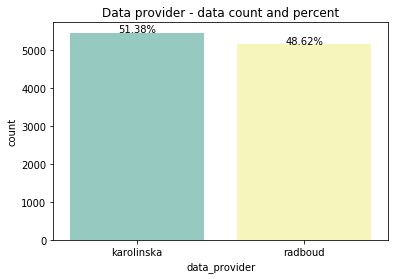

In [14]:
plot_count(train_df, 'data_provider', 'Data provider - data count and percent')

Two research sources are present: Karolinska Institute and Radboud University.

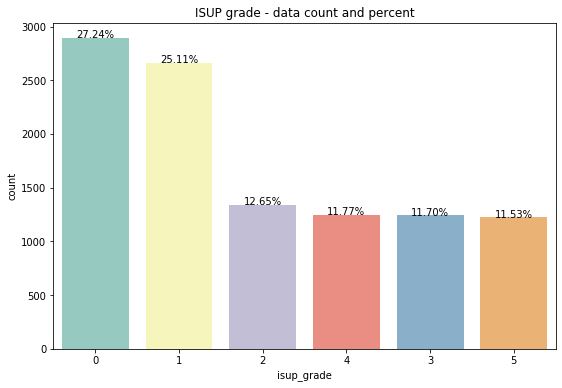

In [15]:
plot_count(train_df, 'isup_grade','ISUP grade - data count and percent', size=3)

In 2012, the International Society of Urologic Pathologists (ISUP) proposed a novel, validated grading system for clear cell renal cell carcinoma (ccRCC) and papillary renal cell carcinoma (pRCC) that has been implemented by the World Health Organization (WHO).This system is based primarily on the nucleoli assessment of the tumors, as follows [1]:

* Grade 1: Inconspicuous nucleoli at ×400 magnification and basophilic
* Grade 2: Clearly visible nucleoli at ×400 magnification and eosinophilic
* Grade 3: Clearly visible nucleoli at ×100 magnification
* Grade 4: Extreme pleomorphism or rhabdoid and/or sarcomatoid morphology  


Majority of data samples in train set have ISUP grade values 0 or 1 (total > 50%) and the rest of the data samples have associated ISUP grades from 2 to 5 with all ranging in the 11-12% each. 

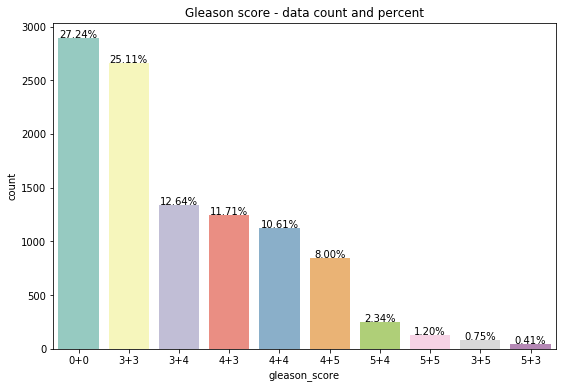

In [16]:
plot_count(train_df, 'gleason_score', 'Gleason score - data count and percent', size=3)

The data is unbalanced with respect of Gleason score values distribution. 

Let's check now relative distribution of ISUP grade anf Gleason score values.

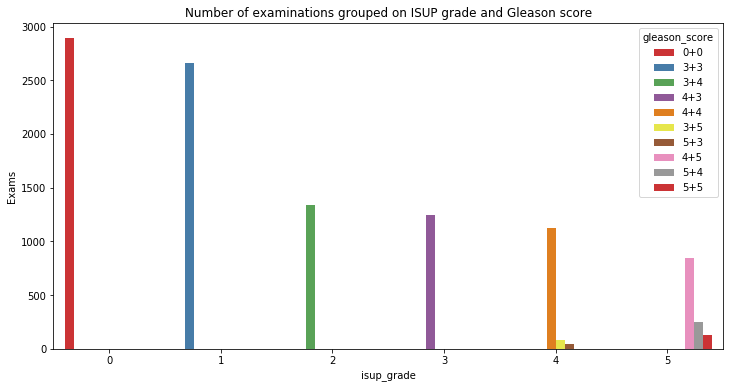

In [17]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_df.groupby('isup_grade')['gleason_score'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'isup_grade', y='Exams',hue='gleason_score',data=df, palette='Set1')
plt.title("Number of examinations grouped on ISUP grade and Gleason score")
plt.show()


Discussion:
* All exams with ISUP grade = 0 have Gleason score 0+0 or negative.
* All exams with ISUP grade = 1 have Gleason score 3+3.
* All exams with ISUP grade = 2 have Gleason score 3+4.
* All exams with ISUP grade = 3 have Gleason score 4+3.
* All exams with ISUP grade = 4 have Gleason score 4+4 (majority), 3+5 or 5+3.
* All exams with ISUP grade = 5 have Gleason score 4+5 (majority), 5+4 or 5+5.

This data distribution can be better visualized using a heatmap.


This seems to be aligned with the correspondence matrix as shown in the following table:

In [18]:
from IPython.display import HTML, display

data = [["Gleason Score", "ISUP Grade"],
        ["0+0", "0"], ["negative", "0"],
        ["3+3", "1"], ["3+4", "2"], ["4+3", "3"], 
        ["4+4", "4"], ["3+5", "4"], ["5+3", "4"],
        ["4+5", "5"], ["5+4", "5"], ["5+5", "5"],
        ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

Gleason Score,ISUP Grade
0+0,0
negative,0
3+3,1
3+4,2
4+3,3
4+4,4
3+5,4
5+3,4
4+5,5
5+4,5


The only misalignment is in the fact that for ISUP Grade 2, in the data we also have Gleason score 4+3 (which also appears for ISUP Grade 3).  

Let's see how Gleason score is grouped by Data source.

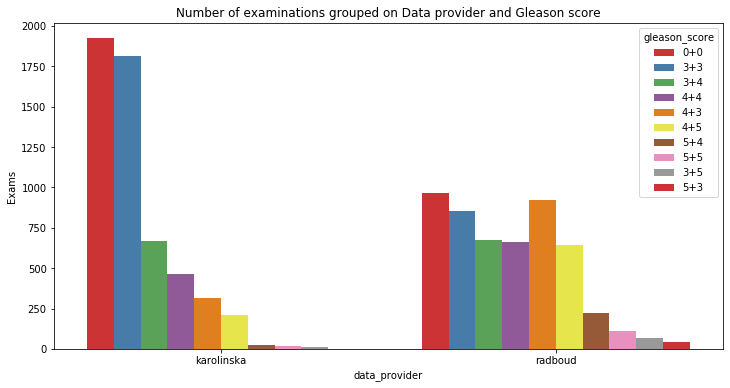

In [19]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('data_provider')['gleason_score'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'data_provider', y='Exams',hue='gleason_score',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Data provider and Gleason score") 
plt.show()


We can observe that all of the 0+0 Gleason score data samples are from Karolinska while from Radboud we have most of negative data.

For Karolinska, next (in terms of frequency) are samples with Gleason score 3+3, 3+4, 4+4.

For Radboud, next (in terms of frequency) most frequent are samples with Gleason score 4+3, 3+3, 3+4, 4+4, 4+5.


Let's see how ISUP grade is distributed with respect of Data provider.

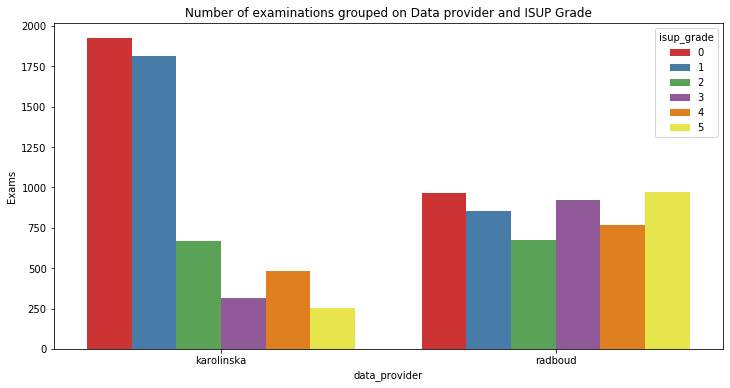

In [20]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('data_provider')['isup_grade'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'data_provider', y='Exams',hue='isup_grade',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Data provider and ISUP Grade") 
plt.show()


Most of the 0 & 1 ISUP Grade samples are originated from Karolinska.  

Most of the 2-5 ISUP Grade samples are originated from Radboud.

## Image samples


Let's plot some image samples from train_images.  


For this visualization, I reused the code from this Kernel: https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization

In [103]:
def show_images(df, read_region=(1780,1950), zoom = 2):
    data = df
    f, ax = plt.subplots(8,3, figsize=(16,36))
    for i,data_row in enumerate(data.iterrows()):
        image = str(data_row[1][0])+'.tiff'
        image_path = os.path.join(original_train_path,image)
        image = skimage.io.MultiImage(image_path)[zoom]
        #spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        #patch = image.read_region(read_region, 0, (256, 256))
        ax[i//3, i%3].imshow(image) 
        #image.close()       
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(f'ID: {data_row[1][0]}\nSource: {data_row[1][1]} ISUP: {data_row[1][2]} Gleason: {data_row[1][3]}')

    plt.show()

In [ ]:
images = [tt.split('.')[0] for tt in os.listdir(original_train_path)][:9]
data_sample = train_labels.loc[train_labels.image_id.isin(images)]

In [41]:
os.listdir(original_train_path)[4:8]

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '001c62abd11fa4b57bf7a6c603a11bb9.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00a97615a51ba4c475bdec8505623bf9.tiff']

In [44]:
img = '008069b542b0439ed69b194674051964.tiff'
image = skimage.io.MultiImage(os.path.join(original_train_path,img))[1]
image.shape

(2176, 5952, 3)

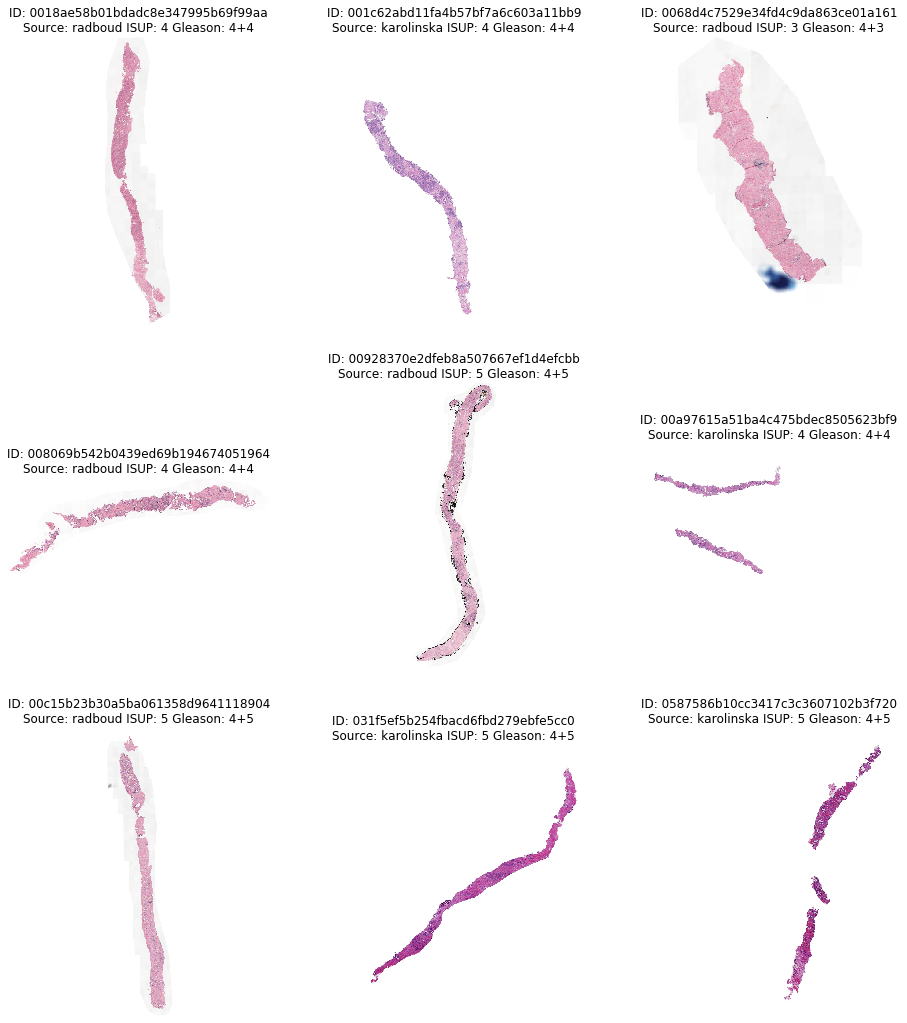

In [87]:

show_images(data_sample)
#data_sample

## Masks samples

Let's show now the masks for the same images.

In [104]:
def display_masks(df, read_region=(0,0), zoom = 2):
    data = df
    f, ax = plt.subplots(8,3, figsize=(16,36))
    for i,data_row in enumerate(data.iterrows()):
        image = str(data_row[1][0])+'_mask.tiff'
        image_path = os.path.join(original_mask_path,image)
        mask_data = skimage.io.MultiImage(image_path)[zoom]
        #image = str(data_row[1][0])+'_mask.tiff'
        #image_path = os.path.join(PATH,"train_label_masks",image)
        #mask = openslide.OpenSlide(image_path)
        
        #mask_data = mask.read_region(read_region, mask.level_count - 1, mask.level_dimensions[-1])
        
        
        cmap = matplotlib.colors.ListedColormap(['black', 'lightgray', 'darkgreen', 'yellow', 'orange', 'red'])
        ax[i//3, i%3].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        #mask.close()       
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(f'ID: {data_row[1][0]}\nSource: {data_row[1][1]} ISUP: {data_row[1][2]} Gleason: {data_row[1][3]}')
        
    plt.show()

In [7]:
images = [tt.split('_')[0] for tt in os.listdir(original_mask_path)]
data_sample = train_labels.loc[train_labels.image_id.isin(images)]

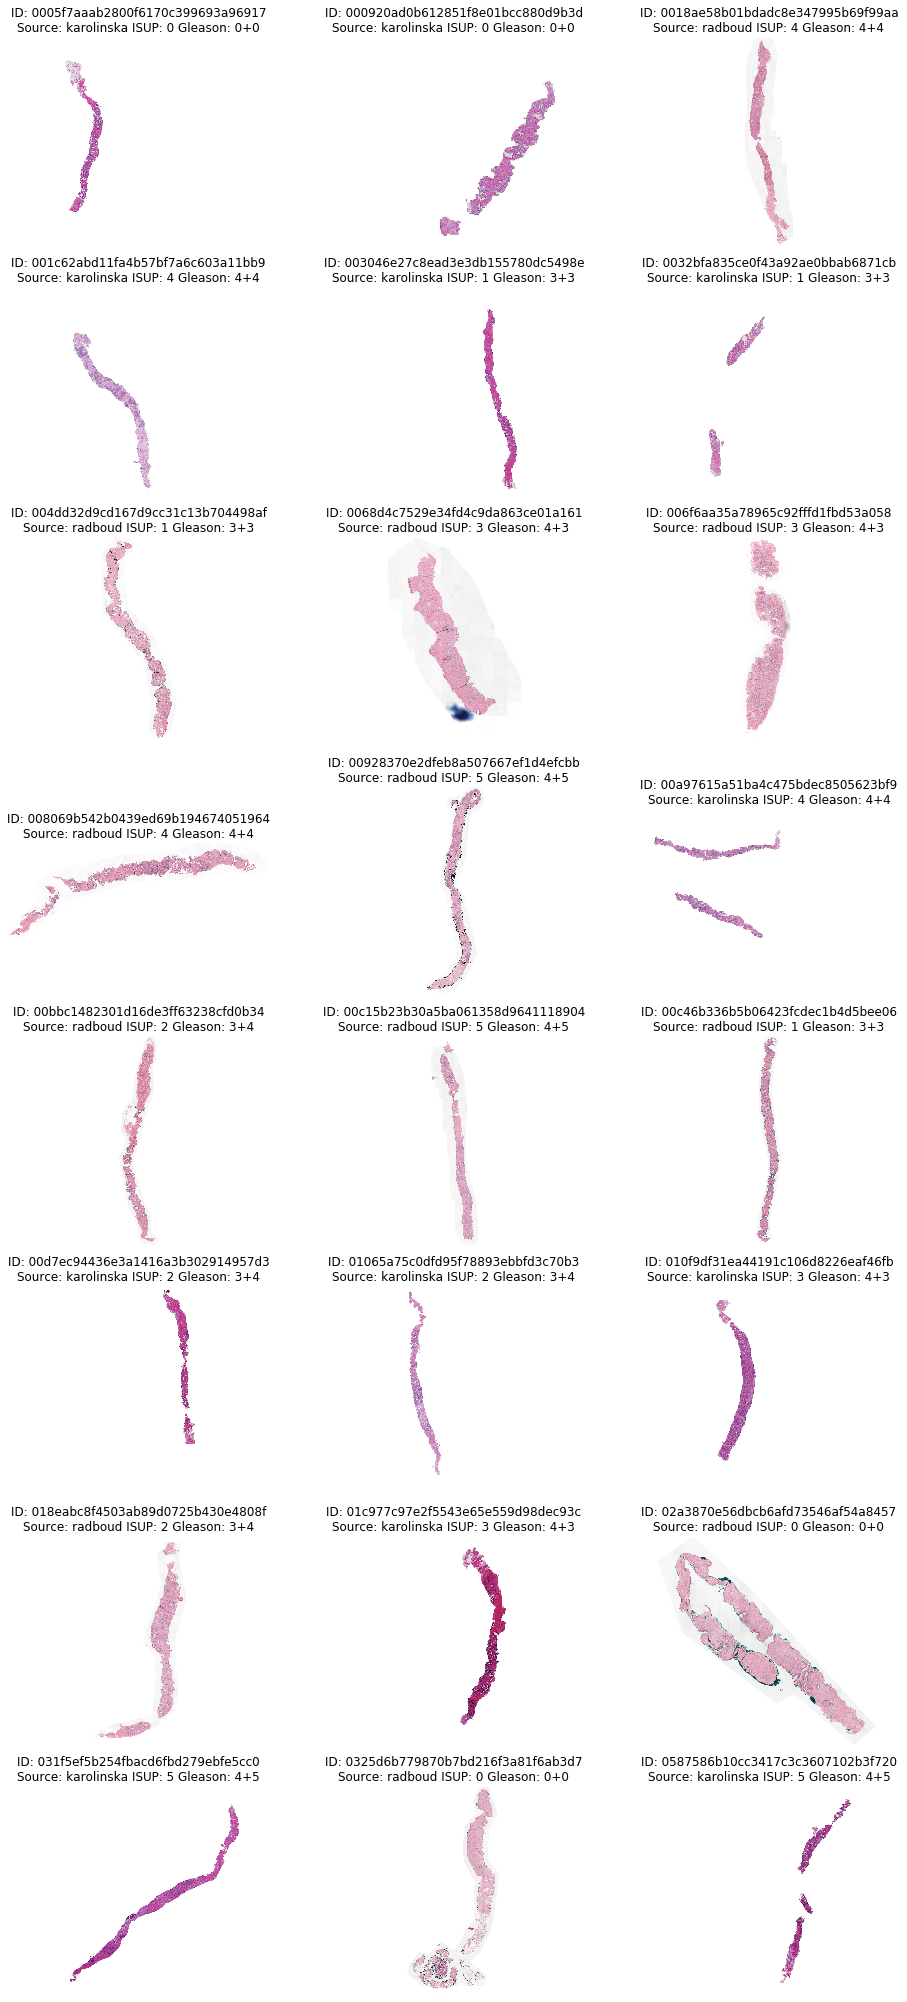

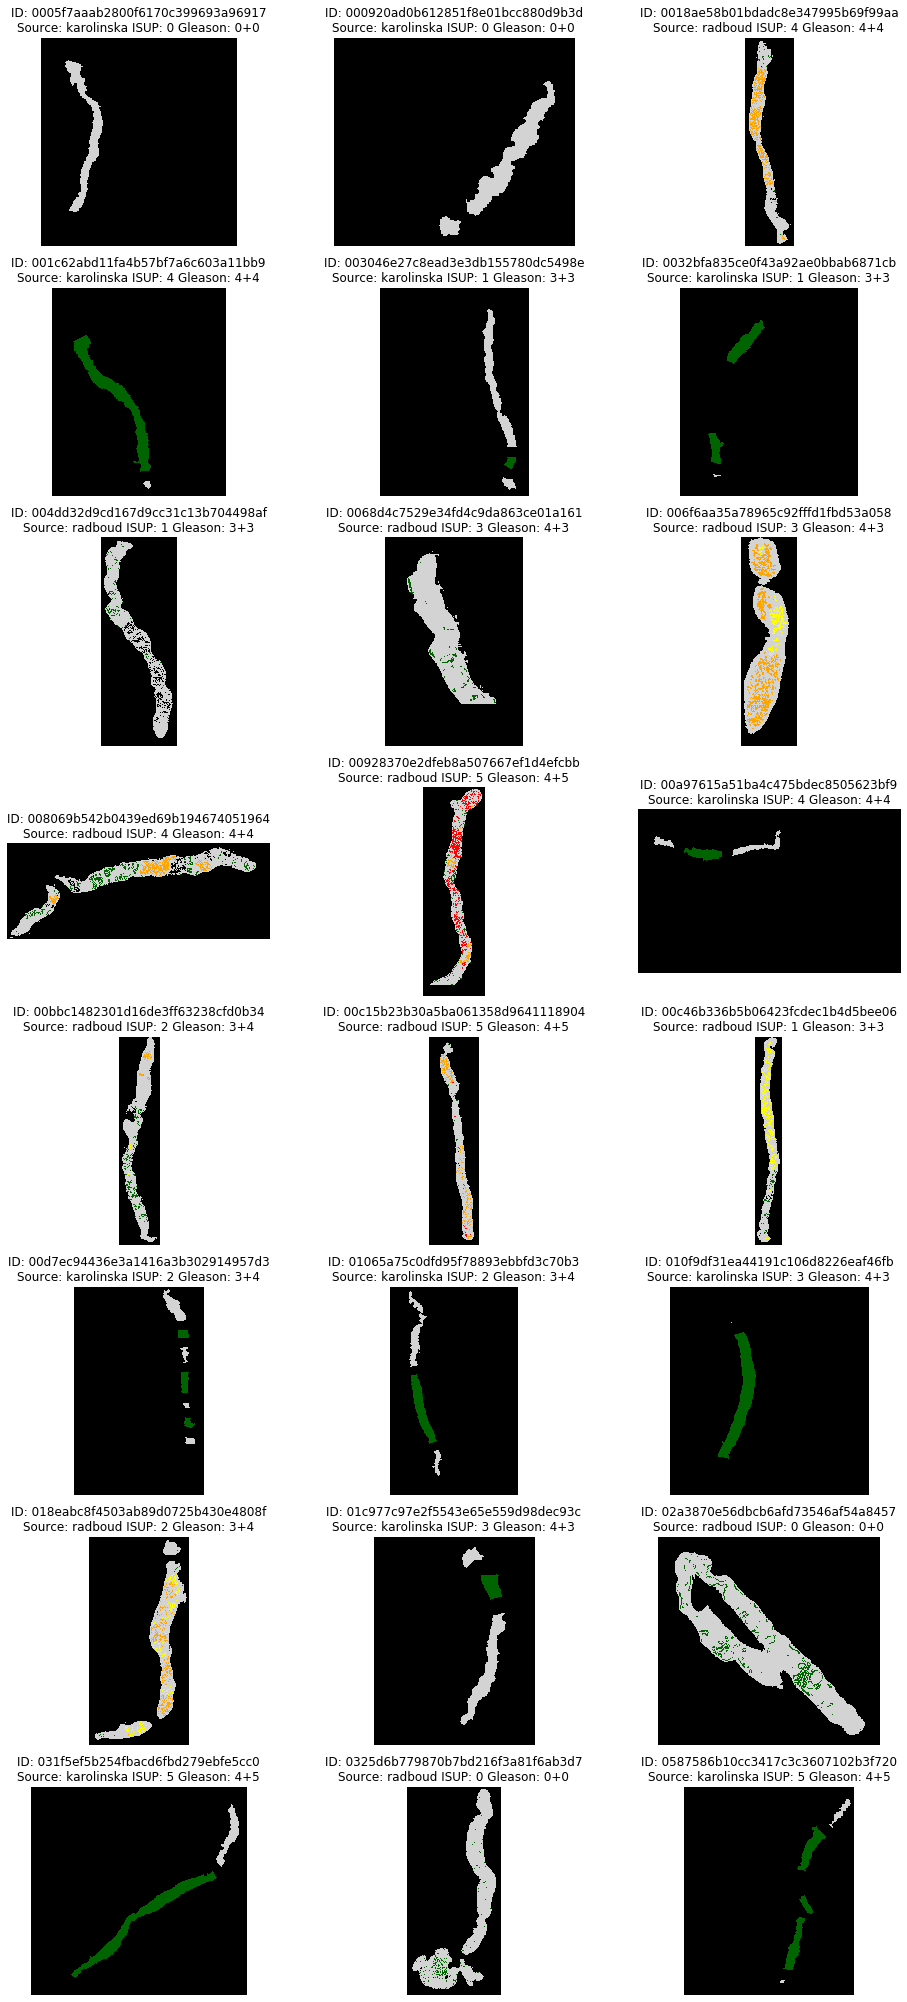

In [106]:

show_images(data_sample)
display_masks(data_sample)
#data_sample

In [130]:
#os.listdir(original_mask_path) #[:3]

In [11]:
ddd = data_sample.loc[data_sample.isup_grade == 4]
ddd

,image_id,data_provider,isup_grade,gleason_score
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
20,008069b542b0439ed69b194674051964,radboud,4,4+4
27,00a97615a51ba4c475bdec8505623bf9,karolinska,4,4+4


In [8]:
def get_masked_area_for_karolinska(df_karolinska, #!: ALL samples from this dataframe will be processed. Use wisely.
                                  mask_input_fold = original_mask_path, 
                                  images_input_fold = original_train_path,
                                  output_path = 'temp',
                                  zoom = 1):
    """
    Since Karolinska masks define cancer area only, and do NOT split cancer area on gleason scores,
    we just output new images of the same size, but with cancer tissue only.
    They can be tiled with 'eliminate_white_area' or further processed with other tecniques.
    """
    
    for i,data_row in enumerate(df_karolinska.iterrows()):        
        mask_image = str(data_row[1][0])+'_mask.tiff'
        save_path = os.path.join(output_path, mask_image)
        mask_path = os.path.join(mask_input_fold, mask_image)
        if data_row[1][3] == '0+0':            
            bashCommand = "cp " + mask_path + " " + save_path
            process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
            output, error = process.communicate()

In [12]:
ddd1 = ddd.loc[ddd.data_provider == 'karolinska']
ddd1

,image_id,data_provider,isup_grade,gleason_score
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
27,00a97615a51ba4c475bdec8505623bf9,karolinska,4,4+4


In [140]:
filename = '01c977c97e2f5543e65e559d98dec93c_mask.tiff'
image_path = os.path.join(original_mask_path, filename)
zoom = 1
ttt = skimage.io.MultiImage(image_path)[zoom]
ppp = ttt[:,:,0]
np.unique(ppp)

array([0, 1, 2], dtype=uint8)

In [241]:
#radboud
filename = '006f6aa35a78965c92fffd1fbd53a058_mask.tiff'
image_path = os.path.join(original_mask_path, filename)
zoom = 0
ttt = skimage.io.MultiImage(image_path)[zoom]
ppp = ttt[:,:,0]
np.unique(ppp)

array([0, 1, 3, 4], dtype=uint8)

In [242]:
real_data = '006f6aa35a78965c92fffd1fbd53a058.tiff'
real_path = os.path.join(original_train_path, real_data)
hhh = skimage.io.MultiImage(real_path)[zoom]
hhh.shape

(7680, 2048, 3)

In [243]:
rrr = ttt.shape

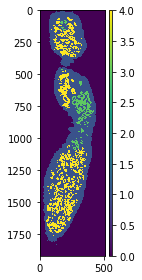

In [173]:
skimage.io.imshow(ppp)

In [244]:
ppp1 = np.where((ppp == 3))
ppp1
#(a >= 6) & (a <=10))
#skimage.io.imshow(ppp1)

(array([ 240,  240,  240, ..., 4410, 4411, 4411]),
 array([ 430,  431,  432, ..., 1487, 1486, 1487]))

In [318]:
type(ppp1[0])

numpy.ndarray

In [245]:
y1 = np.array(ppp1[0])
x1 = np.array(ppp1[1])

In [246]:
fff = np.zeros(rrr)


In [231]:
#hhh[750, 330]

array([224, 168, 190], dtype=uint8)

In [247]:
fff[y1, x1, :] = [1, 1, 1]
#fff[750, 330]

In [248]:
fff = fff.astype(int)
#fff[750, 330]

In [161]:
yyy = np.array(list(zip(ppp1[0], ppp1[1])))
yyy

array([[  90, 2237],
       [  90, 2238],
       [  90, 2239],
       ...,
       [8603, 1035],
       [8603, 1036],
       [8603, 1037]])

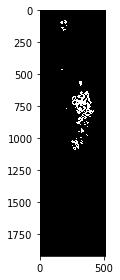

In [206]:
skimage.io.imshow(fff)

In [249]:
%time iii = hhh*fff
#iii[750, 330]

CPU times: user 114 ms, sys: 102 ms, total: 217 ms
Wall time: 217 ms


In [250]:
iii.shape

(7680, 2048, 3)

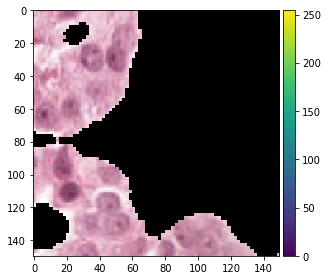

In [255]:
skimage.io.imshow(iii[3000:3150, 1500:1650])


### Gleason score = 5+5

Let's look now to few images and associated masks for samples with Gleason score (5+5).

total samples (Gleason score=5+5): 127


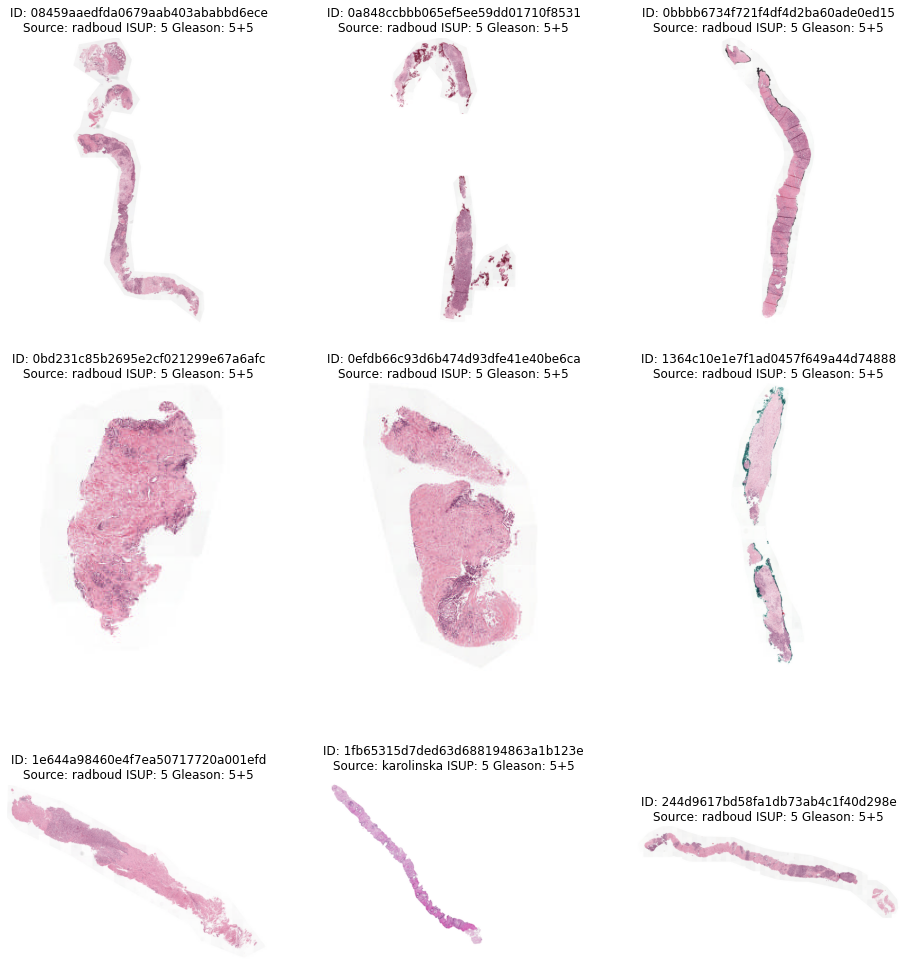

In [32]:
sample_images = list(train_df.loc[train_df.gleason_score=="5+5", "image_id"])
print(f"total samples (Gleason score=5+5): {len(sample_images)}")
sample_images = [ '08459aaedfda0679aab403ababbd6ece','0a848ccbbb065ef5ee59dd01710f8531', '0bbbb6734f721f4df4d2ba60ade0ed15', 
                 '0bd231c85b2695e2cf021299e67a6afc',  '0efdb66c93d6b474d93dfe41e40be6ca', '1364c10e1e7f1ad0457f649a44d74888', 
                 '1e644a98460e4f7ea50717720a001efd',  '1fb65315d7ded63d688194863a1b123e', '244d9617bd58fa1db73ab4c1f40d298e']
data_sample = train_df.loc[train_df.image_id.isin(sample_images)]
show_images1(data_sample)

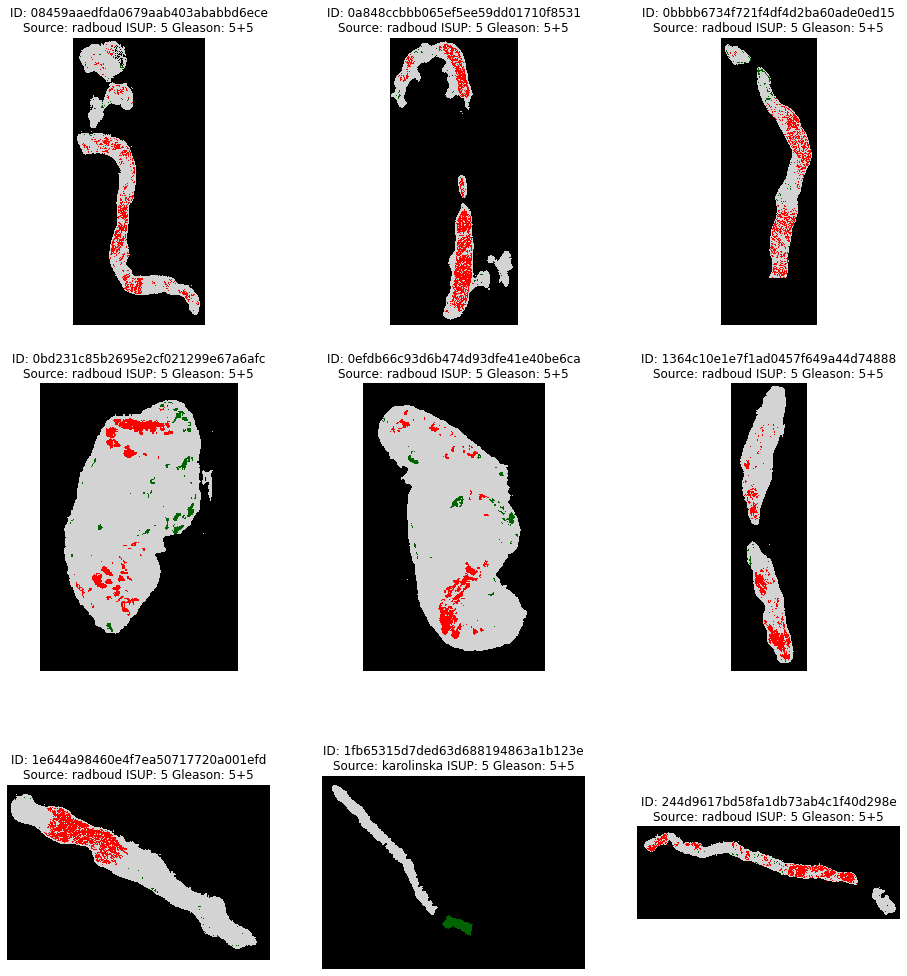

In [33]:
display_masks(data_sample)

### Gleason score = 4+5

Let's look now to few images and associated masks for samples with Gleason score (4+5).

total samples (Gleason score=4+5): 849


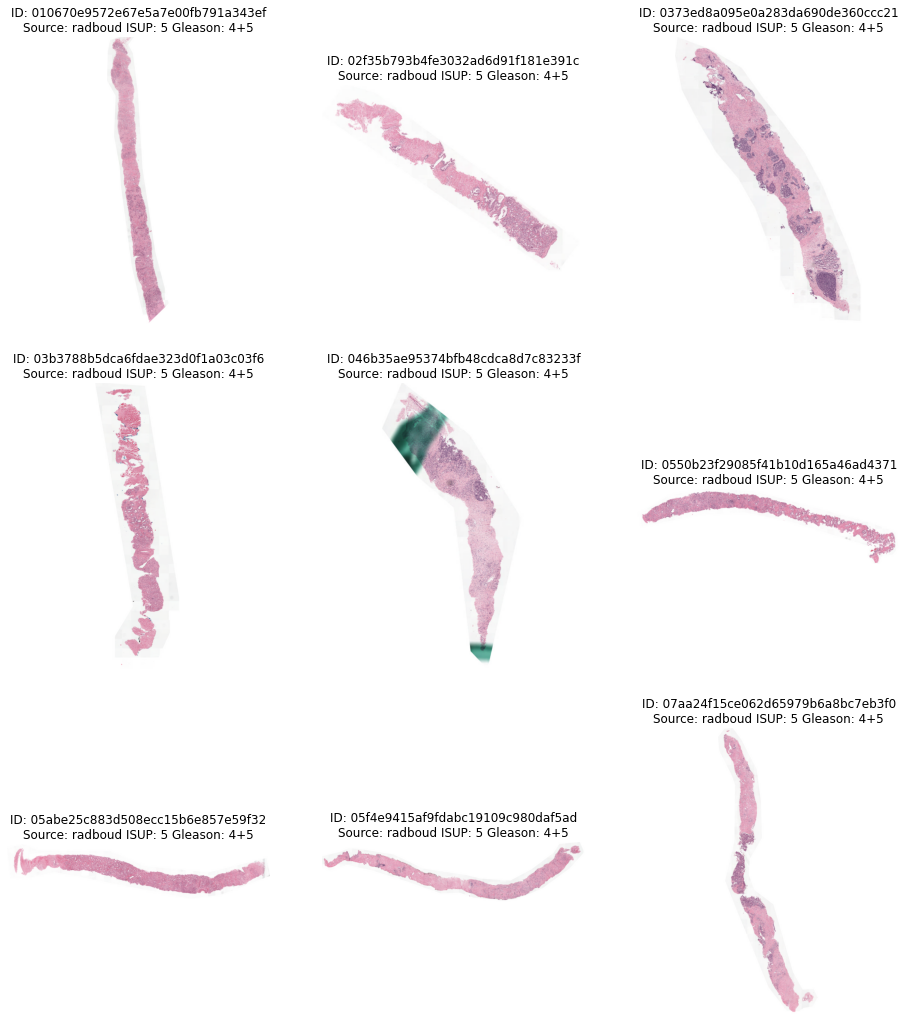

In [34]:
sample_images = list(train_df.loc[train_df.gleason_score=="4+5", "image_id"])
print(f"total samples (Gleason score=4+5): {len(sample_images)}")
sample_images = ['010670e9572e67e5a7e00fb791a343ef', '02f35b793b4fe3032ad6d91f181e391c', '0373ed8a095e0a283da690de360ccc21',
                 '03b3788b5dca6fdae323d0f1a03c03f6', '046b35ae95374bfb48cdca8d7c83233f', '0550b23f29085f41b10d165a46ad4371', 
                 '05abe25c883d508ecc15b6e857e59f32', '05f4e9415af9fdabc19109c980daf5ad',   '07aa24f15ce062d65979b6a8bc7eb3f0']
data_sample = train_df.loc[train_df.image_id.isin(sample_images)]
show_images1(data_sample)

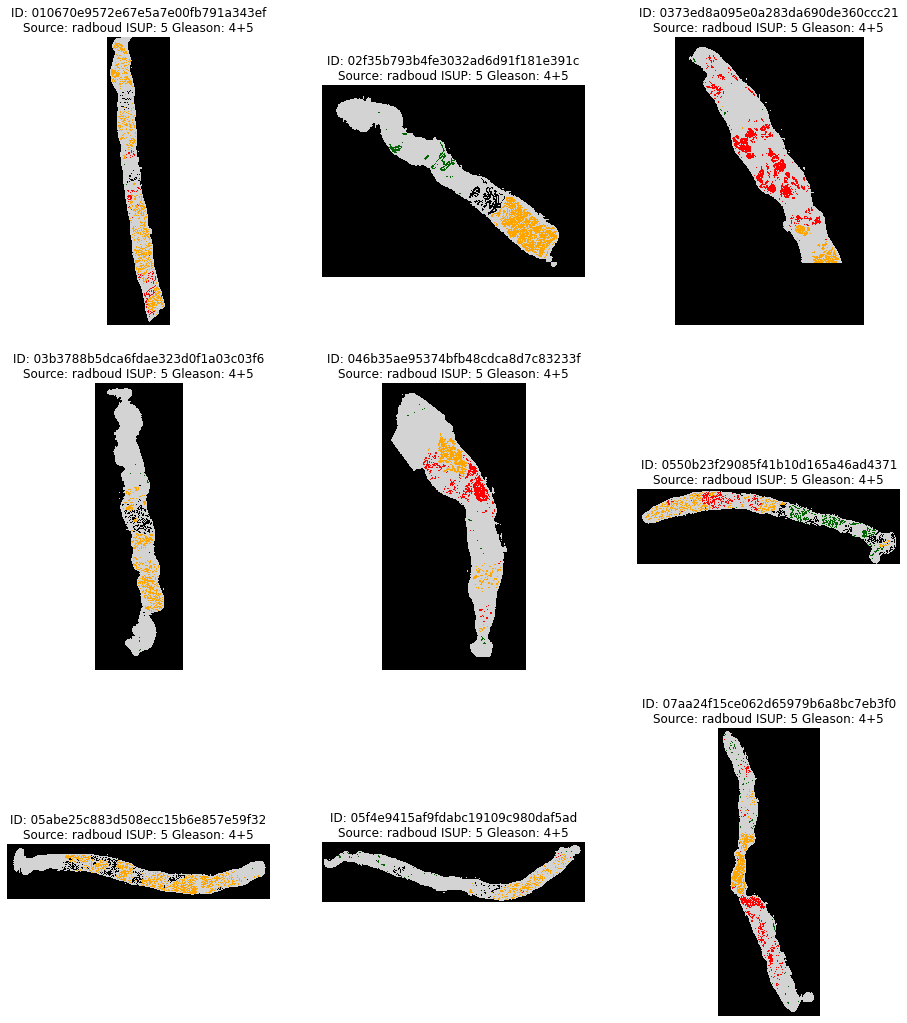

In [35]:
display_masks(data_sample)

### Gleason score = 3+4

Let's look now to images with Gleason score 3+4.

total samples (Gleason score=3+4): 1342


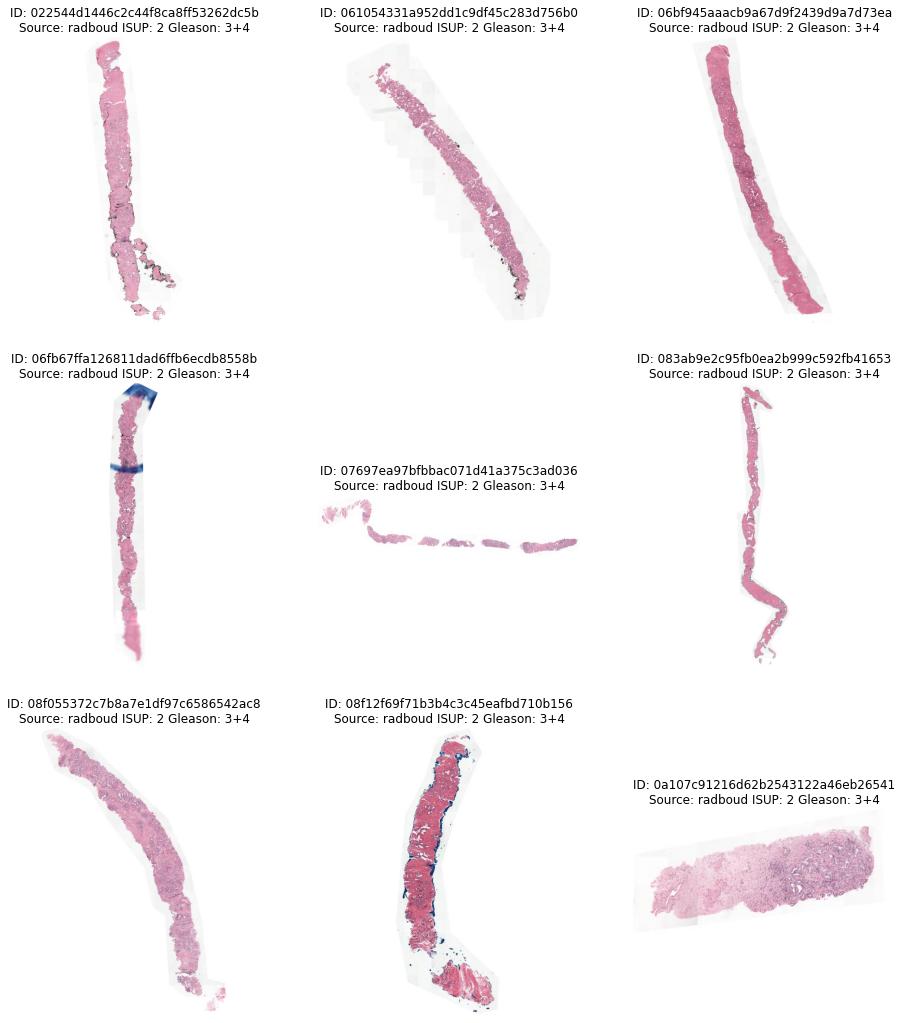

In [36]:
sample_images = list(train_df.loc[train_df.gleason_score=="3+4", "image_id"])
print(f"total samples (Gleason score=3+4): {len(sample_images)}")
sample_images =[
   '022544d1446c2c44f8ca8ff53262dc5b', '061054331a952dd1c9df45c283d756b0', '06bf945aaacb9a67d9f2439d9a7d73ea', 
    '06fb67ffa126811dad6ffb6ecdb8558b', '07697ea97bfbbac071d41a375c3ad036', '083ab9e2c95fb0ea2b999c592fb41653', 
    '08f055372c7b8a7e1df97c6586542ac8', '08f12f69f71b3b4c3c45eafbd710b156', '0a107c91216d62b2543122a46eb26541']
data_sample = train_df.loc[train_df.image_id.isin(sample_images[0:9])]
show_images1(data_sample)

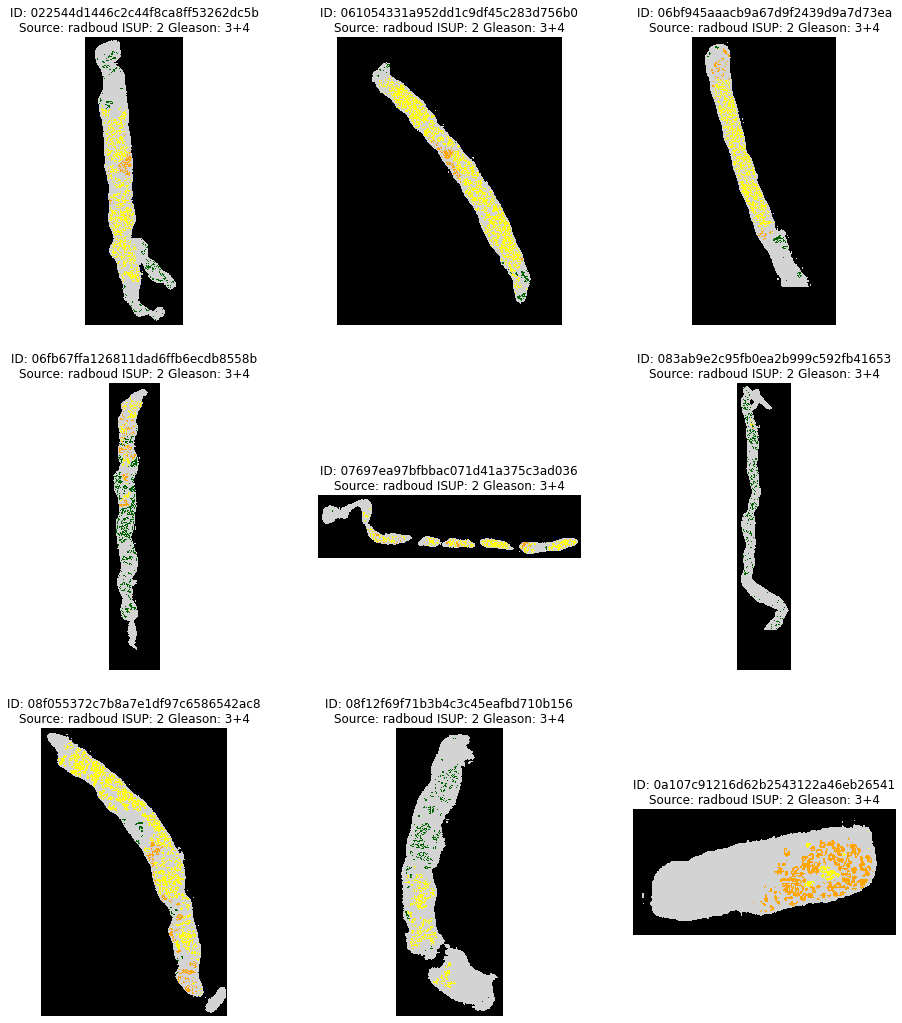

In [37]:
display_masks(data_sample)

### Gleason score = 3+3

Let's look now to images with Gleason score 3+3.


total samples (Gleason score=3+3): 2666


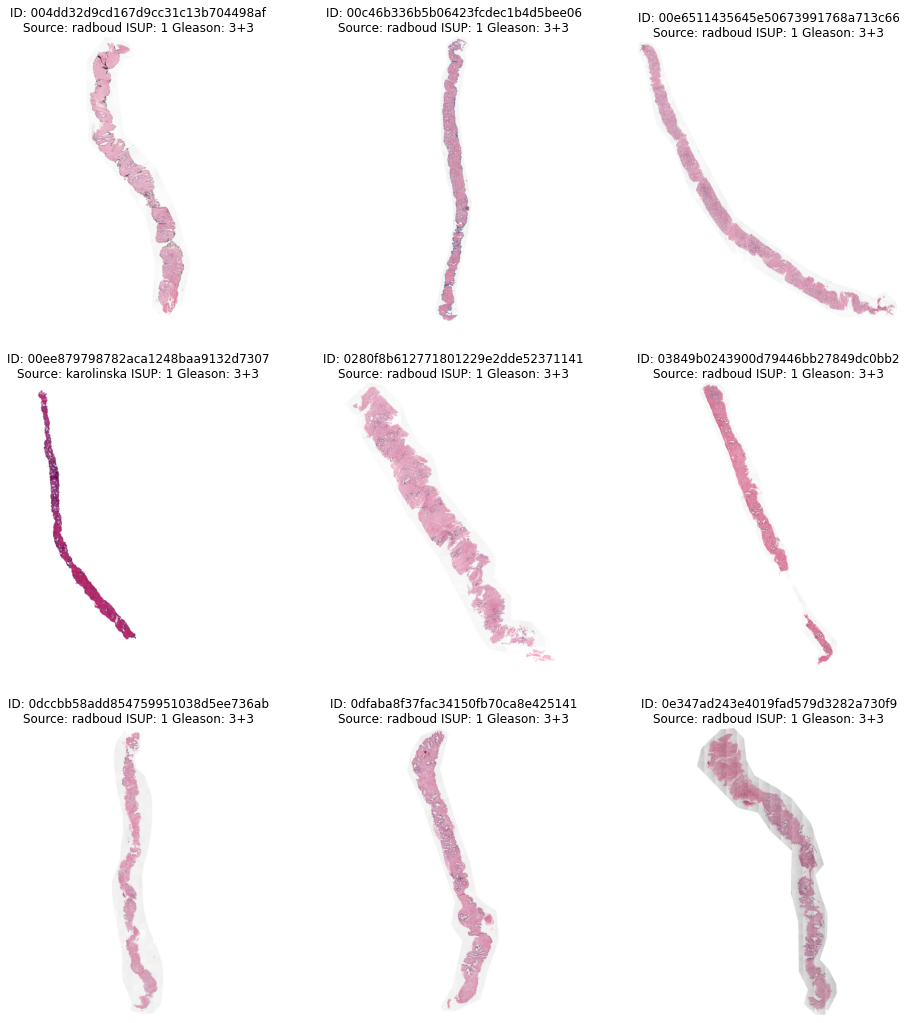

In [38]:
sample_images = list(train_df.loc[train_df.gleason_score=="3+3", "image_id"])
print(f"total samples (Gleason score=3+3): {len(sample_images)}")
sample_images =[
 '004dd32d9cd167d9cc31c13b704498af', '00c46b336b5b06423fcdec1b4d5bee06', '00e6511435645e50673991768a713c66',
 '00ee879798782aca1248baa9132d7307', '0280f8b612771801229e2dde52371141', '03849b0243900d79446bb27849dc0bb2', 
 '0dccbb58add854759951038d5ee736ab', '0dfaba8f37fac34150fb70ca8e425141',  '0e347ad243e4019fad579d3282a730f9']
data_sample = train_df.loc[train_df.image_id.isin(sample_images[0:9])]
show_images1(data_sample)

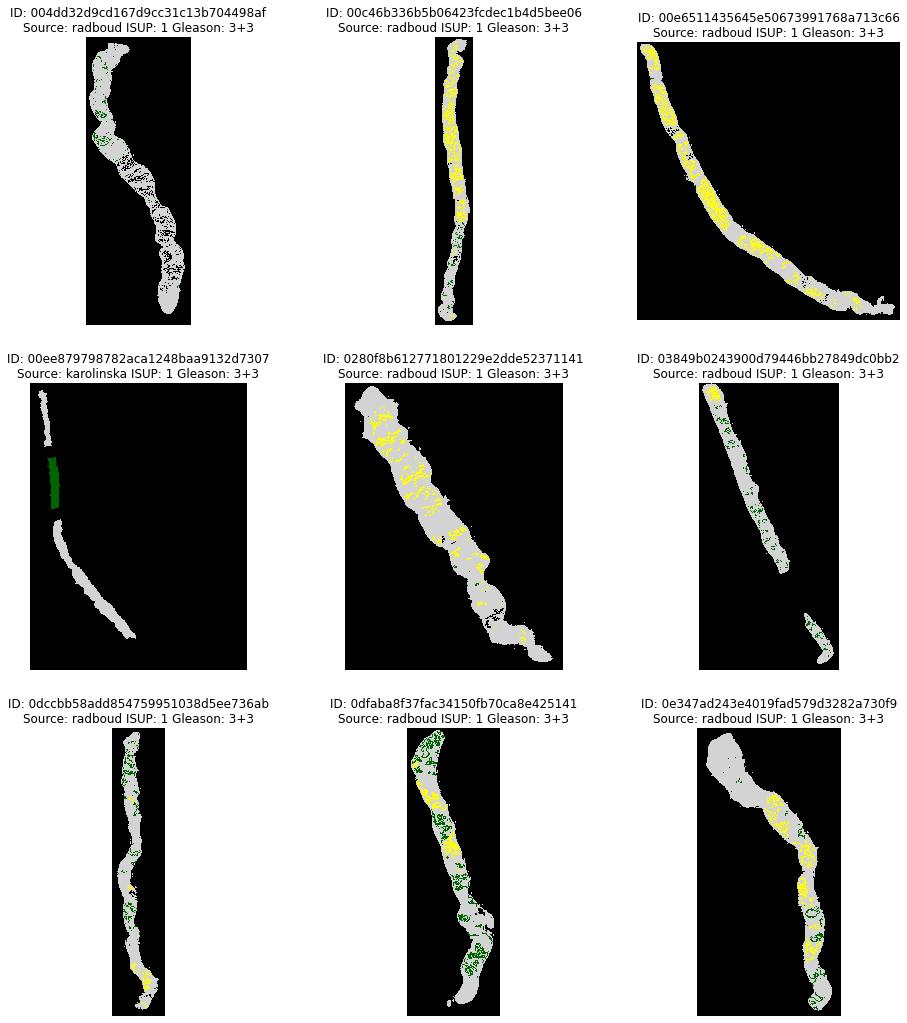

In [39]:
display_masks(data_sample)


## Extract image characteristics

Let's parse all images for train data to extract image characteristics.

In [40]:
import time
start_time = time.time()
slide_dimensions, spacings, level_counts = [], [], []

for image_id in train_df.image_id:
    image = str(image_id)+'.tiff'
    image_path = os.path.join(PATH,"train_images",image)
    slide = openslide.OpenSlide(image_path)
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    slide_dimensions.append(slide.dimensions)
    spacings.append(spacing)
    level_counts.append(slide.level_count)
    slide.close()
    del slide

train_df['width']  = [i[0] for i in slide_dimensions]
train_df['height'] = [i[1] for i in slide_dimensions]
train_df['spacing'] = spacings
train_df['level_count'] = level_counts

end_time = time.time()
print(f"Total processing time: {round(end_time - start_time,2)} sec.")

Total processing time: 381.1 sec.


In [41]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,width,height,spacing,level_count
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,27648,29440,0.452018,3
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,15360,13312,0.452018,3
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,5888,25344,0.486188,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,23904,28664,0.503198,3
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,28672,34560,0.452018,3


Let's now represent the distribution of image dimmensions (width, height), the spacing and level_count, also related to the other features, namely data_provide, isup_grade and gleason_score.

In [42]:
print(f" level count: {train_df.level_count.nunique()}")
print(f" spacing: {train_df.spacing.nunique()}")

 level count: 1
 spacing: 3


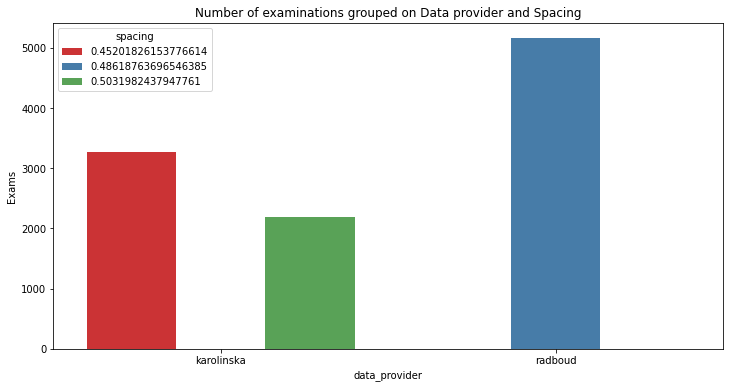

In [43]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('data_provider')['spacing'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'data_provider', y='Exams',hue='spacing',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Data provider and Spacing") 
plt.show()

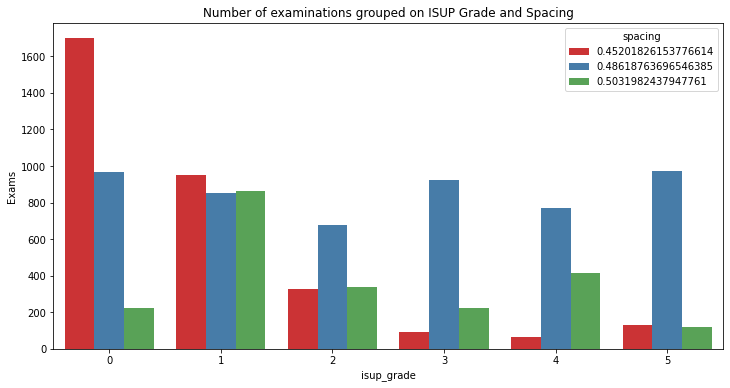

In [44]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('isup_grade')['spacing'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'isup_grade', y='Exams',hue='spacing',data=df, palette='Set1') 
plt.title("Number of examinations grouped on ISUP Grade and Spacing") 
plt.show()

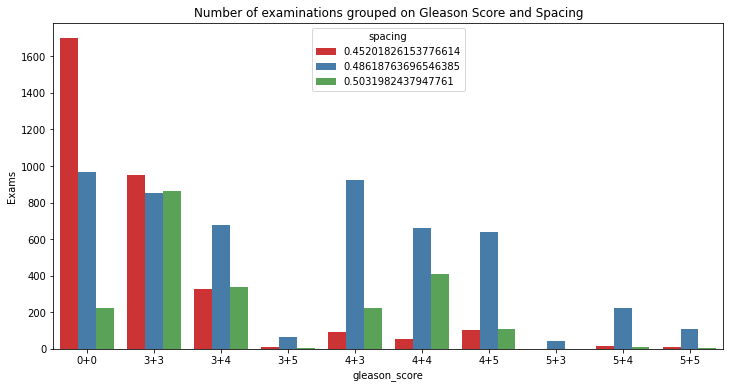

In [45]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('gleason_score')['spacing'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'gleason_score', y='Exams',hue='spacing',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Gleason Score and Spacing") 
plt.show()

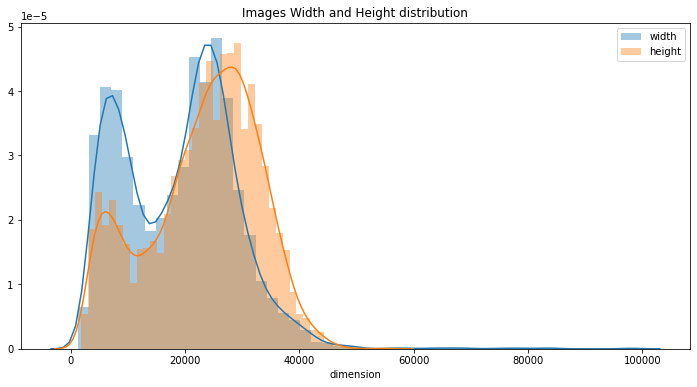

In [46]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
sns.distplot(train_df['width'], kde=True, label='width')
sns.distplot(train_df['height'], kde=True, label='height')
plt.xlabel('dimension')
plt.title('Images Width and Height distribution')
plt.legend()
plt.show()

In [47]:
def plot_distribution_grouped(feature, feature_group, hist_flag=True):
    fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
    for f in train_df[feature_group].unique():
        df = train_df.loc[train_df[feature_group] == f]
        sns.distplot(df[feature], hist=hist_flag, label=f)
    plt.title(f'Images {feature} distribution, grouped by {feature_group}')
    plt.legend()
    plt.show()

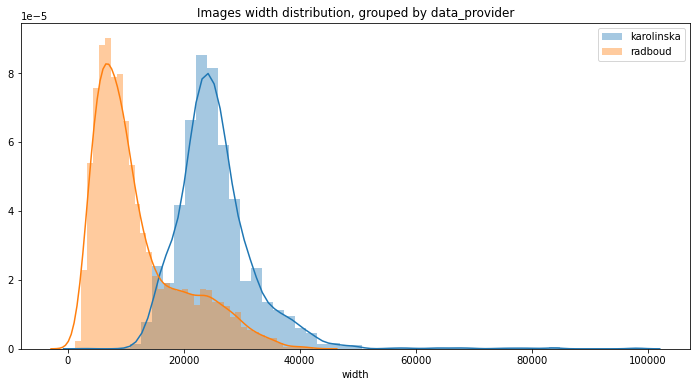

In [48]:
plot_distribution_grouped('width', 'data_provider')

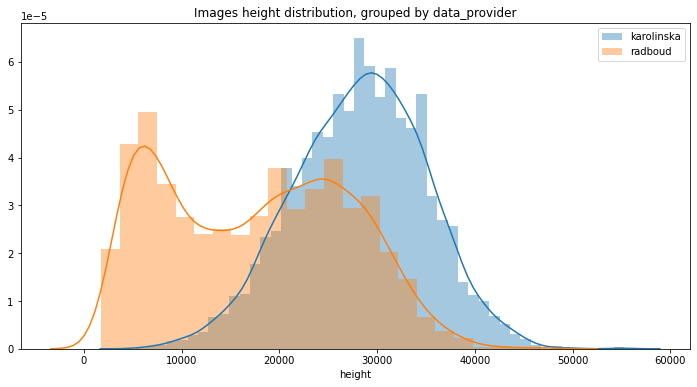

In [49]:
plot_distribution_grouped('height', 'data_provider')

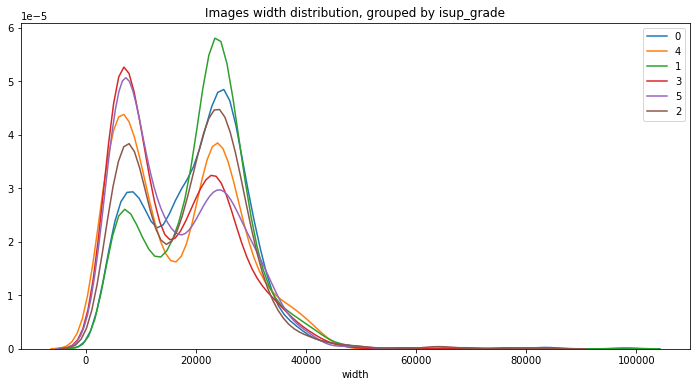

In [50]:
plot_distribution_grouped('width', 'isup_grade', False)

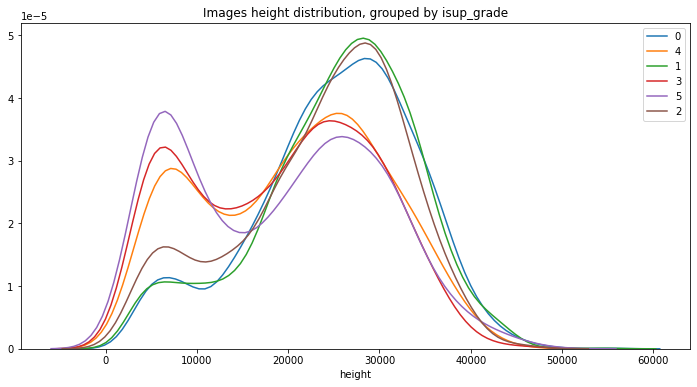

In [51]:
plot_distribution_grouped('height', 'isup_grade', False)

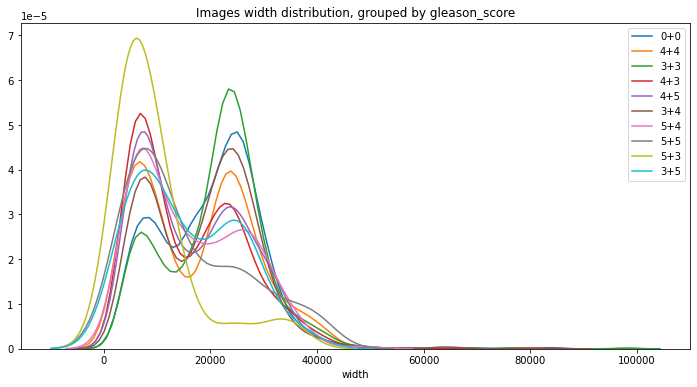

In [52]:
plot_distribution_grouped('width', 'gleason_score', False)

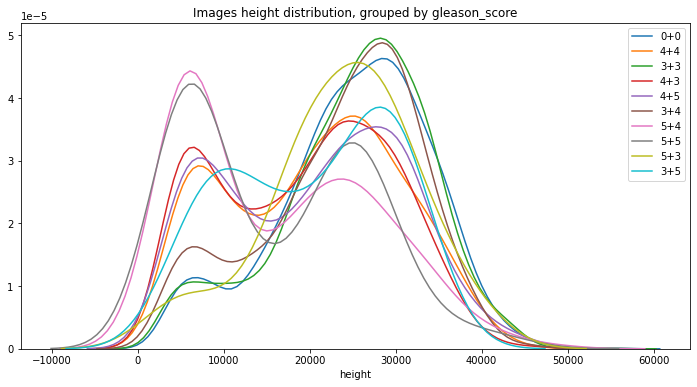

In [53]:
plot_distribution_grouped('height', 'gleason_score', False)

# References

[1] YiFen Zhang, MD, PhD, Pathology Grading of Renal Cell Carcinoma, https://emedicine.medscape.com/article/1612022-overview  
[2] Rohit Singh, PANDA - EDA + Better Visualization, https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization  
[3] Dhananjay Raut, PANDA: EDA All you need to know, https://www.kaggle.com/dhananjay3/panda-eda-all-you-need-to-know
